In [1]:
import os
import re
import pandas as pd
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def AUC_plot(fpr, tpr, thresholds, auc):
    fig, ax = plt.subplots()
    i = np.argmax(tpr-fpr)
    th = thresholds[i]
    x = fpr[i]
    y = tpr[i]
    ax.plot(fpr,tpr, "g-", label="AUC="+str(round(auc, 2)))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    try:
        ax.plot([x, x], [0, y], "r:")
        ax.plot([0, x], [y, y], "r:")
    except:
        print('plot except')
    ax.plot([x], [y], "ro", label="th="+str(round(th,2))) 
    ax.legend(loc=4)
    return fig



def pred_recall_plot(precision, recall, thresholds):
    fig, ax = plt.subplots()
    i = np.argmax(precision+recall)
    x = recall[i]
    y = precision[i]
    th = thresholds[i]
    ax.plot(recall, precision, "g-")
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    try:
        ax.plot([x, x], [0, y], "r:")
        ax.plot([0, x], [y, y], "r:")
    except:
        print('plot except')
    ax.plot([x], [y], "ro", label="th="+str(round(th,2))) 
    ax.legend(loc=4)
    ax.set_title('Precision-Recall curve')
    return fig


def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    fig, ax = plt.subplots()
    f1 = f1_score(precision, recall)
    x_f = thresholds[np.where(f1 == max(f1))]
    y_f = max(f1)
    x = thresholds[np.where(precision == recall)]
    y = precision[np.where(precision == recall)]
    ax.axis([0 ,1, np.min(precision), 1])
    ax.plot(thresholds, precision[:-1], "r-", label="Precision", linewidth=2)
    ax.plot(thresholds, recall[:-1], "b-", label="Recall", linewidth=2)
    ax.plot(thresholds, f1[:-1], "m--", label="F1 score", linewidth=2)
    try:
        for i in range(len(x)):
            ax.plot([x[i]], [y[i]], "bo", label="th="+str(round(x[i],2)))
            ax.plot([x[i], x[i]], [0, y[i]], "k:")
    except:
        ax.plot([x], [y], "bo", label="th="+str(round(x[0],2)))
        ax.plot([x, x], [0, y], "k:")
    try:
        for i in range(len(x)):
            ax.plot([x_f[i]], [y_f[i]], "bo", label="th="+str(round(x_f[i],2)))
            ax.plot([x_f[i], x_f[i]], [0, y_f[i]], "k:")
    except:
        ax.plot([x_f], [y_f], "ro", label="th="+str(round(x_f[0],2))) 
        ax.plot([x_f, x_f], [0, y_f], "k:")
    ax.set_xlabel("Threshold")
    ax.grid(True)
    ax.legend()
    return fig

In [3]:
# METRICAS
def younden_idx(real, pred):
    fpr, tpr, thresholds = metrics.roc_curve(real, pred)
    return thresholds[np.argmax(tpr-fpr)]


def pred_recall_thres(precision, recall, thresholds):
    pr_max = thresholds[np.argmax(precision+recall)]
    try:
        pr_cut= thresholds[np.where(precision == recall)][0]
    except:
        pr_cut= thresholds[np.where(precision == recall)]
    if not isinstance(pr_cut, float):
        pr_cut = float('inf')
    return pr_max, pr_cut


def f1_score(precision, recall):
    return 2*(precision*recall)/(precision+recall)


# EXTRACT MAX
def binarize(array, threshold):
    array[array >= threshold] = 1
    array[array < threshold] = 0
    return array

def extract_max(array):
    for i in range(array.shape[0]):
        max = np.argmax(array[i,:])
        array[i,:] = 0
        array[i,max] = 1
    return array


# Cada una de las clases genera un diccionario con las metricas y los plots
def metrics_per_class(real, pred):
    metricas = {}
    fpr, tpr, auc_thresholds = metrics.roc_curve(real, pred)
    auc = metrics.auc(fpr, tpr)
    metricas['auc'] = auc
    metricas['younden'] = younden_idx(real, pred)
    precision, recall, pr_thresholds = metrics.precision_recall_curve(real, pred)
    metricas['pr_max'], metricas['pr_cut'] = pred_recall_thres(precision, 
                                                                            recall, 
                                                                            pr_thresholds)
    plots = {}
    plots['pred_rec_plot'] = pred_recall_plot(precision, recall, pr_thresholds)
    plots['auc_plot'] = AUC_plot(fpr, tpr, auc_thresholds, auc)
    plots['pr_re_th_plot'] = plot_precision_recall_vs_threshold(precision, 
                                                                        recall, 
                                                                        pr_thresholds)
    return metricas, plots


# Por cada prediccion se generan metricas por clase, por combinaciones binarias y por maximo
def metricas_dict(real, pred):
    metrics_dict = {}
    plot_dict = {}
    metricas, plots = metrics_per_class(real, pred[:,0])
    metrics_dict.update(metricas)
    plot_dict.update(plots)
    thresholds = ['younden','pr_max','pr_cut']

    for threshold in thresholds:
        binar = binarize(pred[:,0].copy(), metricas[threshold])
        metrics_dict['f1_score_' + threshold] = metrics.f1_score(real, binar, 
                                                                average = 'weighted')
        metrics_dict['precision_score_' + threshold] = metrics.precision_score(real, 
                                                                            binar, 
                                                                            average = 'weighted')
        metrics_dict['recall_score_' + threshold] = metrics.recall_score(real, 
                                                                        binar, 
                                                                        average = 'weighted')
        metrics_dict['accuracy_score_' + threshold] = metrics.accuracy_score(real, binar)
    
    binar = binarize(pred[:,0].copy(), 0.5)
    metrics_dict['f1_score_' + str(0.5)] = metrics.f1_score(real, binar, 
                                                            average = 'weighted')
    metrics_dict['precision_score_' + str(0.5)] = metrics.precision_score(real, 
                                                                        binar, 
                                                                        average = 'weighted')
    metrics_dict['recall_score_' + str(0.5)] = metrics.recall_score(real, 
                                                                    binar, 
                                                                    average = 'weighted')
    metrics_dict['accuracy_score_' + str(0.5)] = metrics.accuracy_score(real, binar)
    
    binar = extract_max(pred.copy())[:,0]
    metrics_dict['f1_score_' + 'max'] = metrics.f1_score(real, binar, 
                                                            average = 'weighted')
    metrics_dict['precision_score_' + 'max'] = metrics.precision_score(real, 
                                                                        binar, 
                                                                        average = 'weighted')
    metrics_dict['recall_score_' + 'max'] = metrics.recall_score(real, 
                                                                    binar, 
                                                                    average = 'weighted')
    metrics_dict['accuracy_score_' + 'max'] = metrics.accuracy_score(real, binar)

    return metrics_dict, plot_dict

In [4]:
def execute_metrics(df):
    true = np.array(df.real)
    pred = np.array(df[['normal', 'moderado', 'severo']])
    return metricas_dict(true, pred)

# ESTUDIO

In [5]:
path = '/home/mr1142/Documents/Data/global_pneumonia_validation'

In [6]:
path = '/home/mr1142/Documents/Data/global_pneumonia_validation'

In [7]:
path = path + '/val'

In [8]:
[file for file in os.listdir(os.path.join(path, 'model_results')) if bool(re.search('.csv', file))]

['prueba_Xception_fine-08_batch-8_lr--05_auc-93_results.csv',
 'prueba_Xception_fine-07_batch-8_lr--05_auc-92_results.csv',
 'prueba_EffNet3_fine-03_batch-8_lr-001_auc-94_results.csv',
 'completo_3_Xception_fine-08_batch-8_lr-0001_auc-98_results.csv',
 'prueba_Xception_fine-07_batch-8_lr-0001_auc-93_results.csv',
 'prueba_IncResNet_fine-00_batch-8_lr-0001_auc-90_results.csv',
 'prueba_Xception_fine-05_batch-8_lr-0001_auc-94_results.csv',
 'completo_mask_Xception_fine-03_batch-8_lr-0001_auc-99_results.csv',
 'prueba_mask_EffNet3_fine-05_batch-8_lr-001_auc-85_results.csv',
 'prueba_mask_EffNet3_fine-03_batch-8_lr-001_auc-91_results.csv',
 'prueba_Xception_fine-03_batch-8_lr--05_auc-89_results.csv',
 'prueba_IncResNet_fine-07_batch-8_lr-0001_auc-90_results.csv',
 'prueba_EffNet3_fine-07_batch-8_lr--05_auc-86_results.csv',
 'prueba_mask_IncResNet_fine-08_batch-8_lr-0001_auc-92_results.csv',
 'prueba_mask_Xception_fine-08_batch-8_lr--05_auc-91_results.csv',
 'prueba_mask_Xception_fine-03_ba

In [9]:
comparation = pd.read_csv(os.path.join(path, 'results_comparation.csv'))
comparation

,name,auc,younden,pr_max,pr_cut,f1_score_younden,precision_score_younden,recall_score_younden,accuracy_score_younden,f1_score_pr_max,...,recall_score_pr_cut,accuracy_score_pr_cut,f1_score_0.5,precision_score_0.5,recall_score_0.5,accuracy_score_0.5,f1_score_max,precision_score_max,recall_score_max,accuracy_score_max
0,prueba_Xception_fine-08_batch-8_lr--05_auc-93,0.788261,0.725101,0.051096,0,0.720432,0.723169,0.719649,0.719649,0.461680,...,0.44393,0.44393,0.688993,0.716745,0.690374,0.690374,0.671490,0.709831,0.674826,0.674826
1,prueba_mask_Xception_fine-08_batch-8_lr-0001_a...,0.866394,0.102593,0.021691,0,0.778989,0.781785,0.778366,0.778366,0.701898,...,0.44393,0.44393,0.727038,0.772275,0.742640,0.742640,0.741367,0.769328,0.751902,0.751902
2,prueba_Xception_fine-07_batch-8_lr--05_auc-92,0.743871,0.832160,0.049610,0,0.689283,0.689904,0.688885,0.688885,0.380461,...,0.44393,0.44393,0.624009,0.678802,0.632153,0.632153,0.599580,0.669680,0.612636,0.612636
3,prueba_EffNet3_fine-03_batch-8_lr-0001_auc-95,0.842912,0.407719,0.166343,0,0.778442,0.778364,0.778862,0.778862,0.750832,...,0.44393,0.44393,0.777820,0.779327,0.779358,0.779358,0.776196,0.776086,0.776546,0.776546
4,prueba_EffNet3_fine-03_batch-8_lr-001_auc-94,0.817232,0.235888,0.091886,0,0.733658,0.741958,0.732881,0.732881,0.647486,...,0.44393,0.44393,0.734183,0.735206,0.736024,0.736024,0.731315,0.731137,0.731889,0.731889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,prueba_mask_EffNet3_fine-07_batch-8_lr-001_auc-87,0.841140,0.261118,0.030496,0,0.769026,0.770022,0.768607,0.768607,0.695338,...,0.44393,0.44393,0.748537,0.758782,0.753887,0.753887,0.763727,0.765962,0.765796,0.765796
92,completo_layer_mask_Xception_fine-05_batch-8_l...,0.800439,0.083809,0.009772,0,0.721860,0.739647,0.721800,0.721800,0.685450,...,0.44393,0.44393,0.718918,0.719692,0.718492,0.718492,0.718126,0.719004,0.717665,0.717665
93,completo_layer_mask_Xception_fine-03_batch-8_l...,0.755442,0.761662,0.113343,0,0.655388,0.719996,0.663910,0.663910,0.581959,...,0.44393,0.44393,0.629051,0.728781,0.645716,0.645716,0.625031,0.728537,0.642739,0.642739
94,completo_layer_mask_Xception_fine-03_batch-8_l...,0.806600,0.292551,0.061810,0,0.701116,0.758531,0.706583,0.706583,0.674582,...,0.44393,0.44393,0.706355,0.745272,0.709064,0.709064,0.703862,0.744879,0.706914,0.706914


In [11]:
name = 'prueba_Xception_fine-08_batch-8_lr--05_auc-93'

In [12]:
results = pd.read_csv(os.path.join(path, 'model_results',
     name + '_results.csv')).sort_values('name').reset_index(drop = True)

In [14]:
real = pd.read_csv(os.path.join(path, 'data.csv')).sort_values('img_name').reset_index(drop = True)
real['real'] = real.normal
real = real.drop('normal', axis = 1)

In [15]:
real

,path,img_name,viral,bacteria,class,dataset,real
0,/home/mr1142/Documents/Data/neumonia_covid/all...,00000002_000.png,0,0,normal,covid,1
1,/home/mr1142/Documents/Data/neumonia_covid/all...,00000007_000.png,0,0,normal,covid,1
2,/home/mr1142/Documents/Data/neumonia_covid/all...,00000011_004.png,0,0,normal,covid,1
3,/home/mr1142/Documents/Data/neumonia_covid/all...,00000013_016.png,0,0,normal,covid,1
4,/home/mr1142/Documents/Data/neumonia_covid/all...,00000018_000.png,0,0,normal,covid,1
...,...,...,...,...,...,...,...
6041,/home/mr1142/Documents/Data/chest_xray/train/P...,person997_bacteria_2926.jpeg,0,1,bacterial,ped,0
6042,/home/mr1142/Documents/Data/chest_xray/train/P...,person997_virus_1678.jpeg,1,0,viral,ped,0
6043,/home/mr1142/Documents/Data/chest_xray/test/PN...,person99_bacteria_474.jpeg,0,1,bacterial,ped,0
6044,/home/mr1142/Documents/Data/chest_xray/train/P...,person9_bacteria_40.jpeg,0,1,bacterial,ped,0


In [11]:
df = pd.concat([real, results], axis = 1)

In [12]:
np.where(df.img_name != df.name)

(array([], dtype=int64),)

In [13]:
df.head()

,path,img_name,viral,bacteria,class,dataset,real,name,normal,moderado,severo
0,/home/mr1142/Documents/Data/neumonia_covid/all...,00000002_000.png,0,0,normal,covid,1,00000002_000.png,0.721225,0.271275,0.007500
1,/home/mr1142/Documents/Data/neumonia_covid/all...,00000005_000.png,0,0,normal,covid,1,00000005_000.png,0.949030,0.049911,0.001059
2,/home/mr1142/Documents/Data/neumonia_covid/all...,00000005_003.png,0,0,normal,covid,1,00000005_003.png,0.981545,0.018145,0.000310
3,/home/mr1142/Documents/Data/neumonia_covid/all...,00000005_004.png,0,0,normal,covid,1,00000005_004.png,0.991882,0.007990,0.000129
4,/home/mr1142/Documents/Data/neumonia_covid/all...,00000005_005.png,0,0,normal,covid,1,00000005_005.png,0.998871,0.001114,0.000015


In [25]:
comparation.loc[len(comparation)] = [name] + list(a[0].values())

## TOTAL

AttributeError: 'list' object has no attribute 'loc'

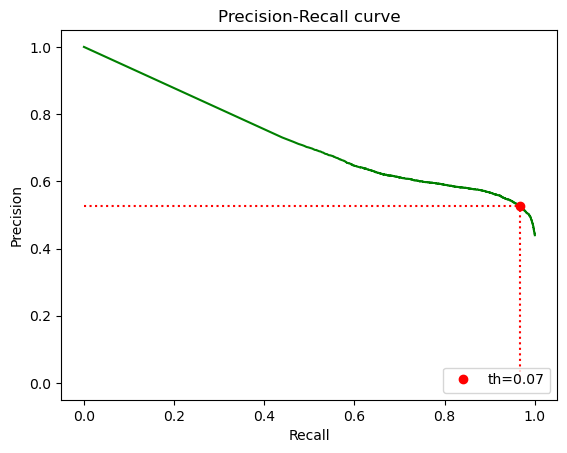

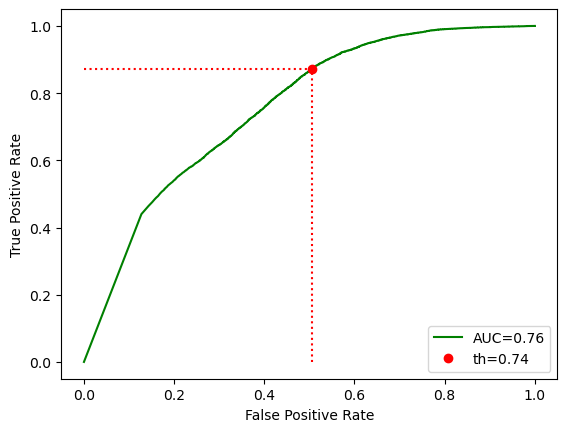

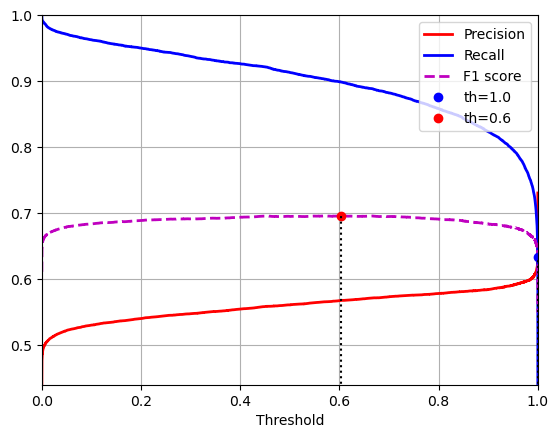

In [19]:
execute_metrics(df)

({'auc': 0.7579660031285012,
  'younden': 0.7427282929420471,
  'pr_max': 0.0708824172616005,
  'pr_cut': 0.999704658985138,
  'f1_score_younden': 0.6526119847225018,
  'precision_score_younden': 0.719384640488039,
  'recall_score_younden': 0.6609440640402237,
  'accuracy_score_younden': 0.6609440640402237,
  'f1_score_pr_max': 0.5633439894572859,
  'precision_score_pr_max': 0.7495756745754084,
  'recall_score_pr_max': 0.6022294995203599,
  'accuracy_score_pr_max': 0.6022294995203599,
  'f1_score_pr_cut': 0.6778141642684662,
  'precision_score_pr_cut': 0.6778141642684662,
  'recall_score_pr_cut': 0.6778141642684662,
  'accuracy_score_pr_cut': 0.6778141642684662,
  'f1_score_0.5': 0.6317852739767212,
  'precision_score_0.5': 0.7314613745282378,
  'recall_score_0.5': 0.6473156693460356,
  'accuracy_score_0.5': 0.6473156693460356,
  'f1_score_max': 0.6270620519400473,
  'precision_score_max': 0.7304126491416647,
  'recall_score_max': 0.6436439416493004,
  'accuracy_score_max': 0.643643941

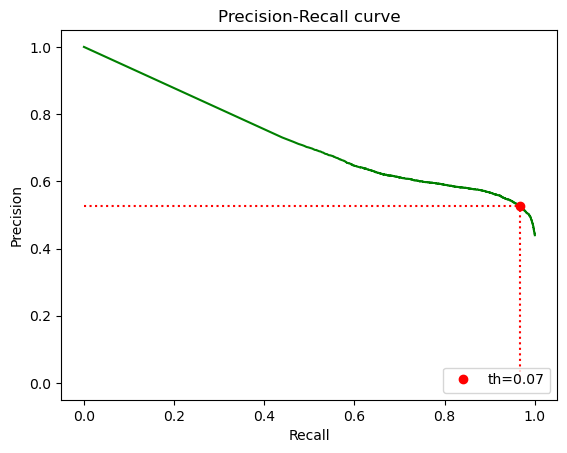

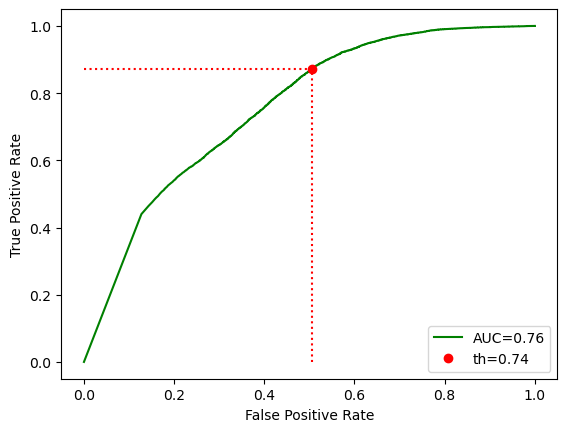

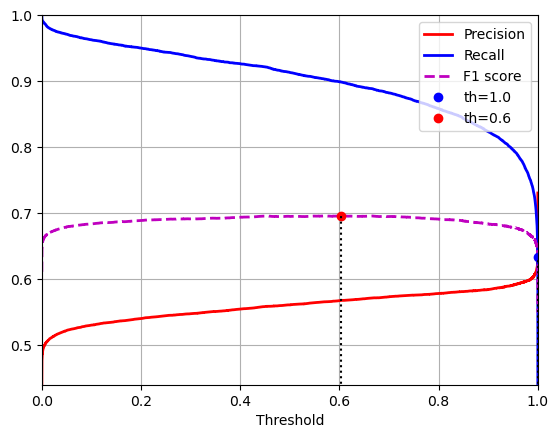

In [14]:
execute_metrics(df)

## PEDIATRICO

/tmp/ipykernel_26545/1113631250.py:19: RuntimeWarning: invalid value encountered in divide
  return 2*(precision*recall)/(precision+recall)


({'auc': 0.8157306983754815,
  'younden': 0.2409580051898956,
  'pr_max': 0.0297422241419553,
  'pr_cut': 0.3879201412200928,
  'f1_score_younden': 0.7630784432975704,
  'precision_score_younden': 0.78860361258485,
  'recall_score_younden': 0.7527397260273972,
  'accuracy_score_younden': 0.7527397260273972,
  'f1_score_pr_max': 0.5057971411348837,
  'precision_score_pr_max': 0.7905726181425579,
  'recall_score_pr_max': 0.5075342465753425,
  'accuracy_score_pr_max': 0.5075342465753425,
  'f1_score_pr_cut': 0.7832191780821918,
  'precision_score_pr_cut': 0.7832191780821918,
  'recall_score_pr_cut': 0.7832191780821918,
  'accuracy_score_pr_cut': 0.7832191780821918,
  'f1_score_0.5': 0.7817739308166044,
  'precision_score_0.5': 0.7795442302828074,
  'recall_score_0.5': 0.7905821917808219,
  'accuracy_score_0.5': 0.7905821917808219,
  'f1_score_max': 0.7795101286254752,
  'precision_score_max': 0.7767033217173063,
  'recall_score_max': 0.7866438356164384,
  'accuracy_score_max': 0.786643835

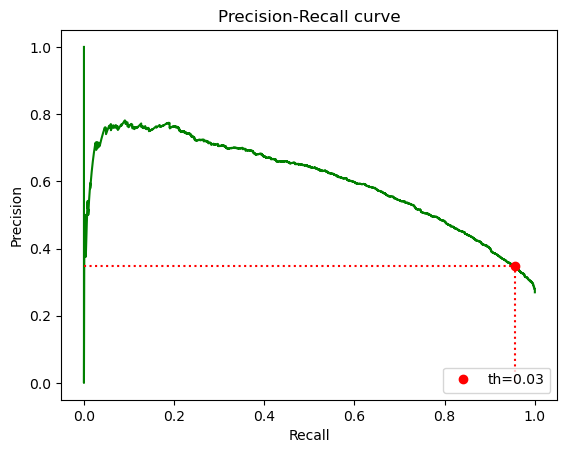

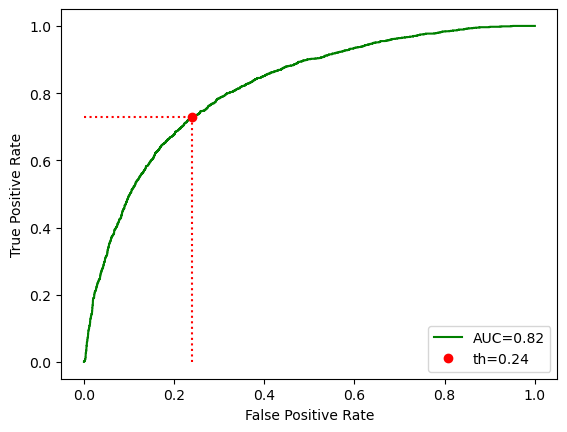

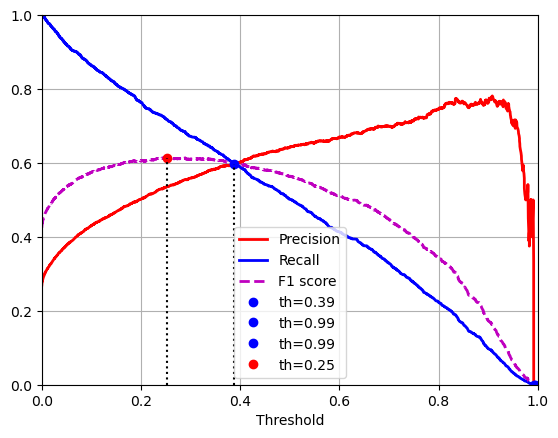

In [154]:
ped = df[df.dataset == 'ped']
execute_metrics(ped)

## COVID

/tmp/ipykernel_26545/1113631250.py:19: RuntimeWarning: invalid value encountered in divide
  return 2*(precision*recall)/(precision+recall)


({'auc': 0.8563994178930427,
  'younden': 0.4797577261924743,
  'pr_max': 0.173030599951744,
  'pr_cut': 0.7476467490196228,
  'f1_score_younden': 0.8056972916505051,
  'precision_score_younden': 0.8177109139886944,
  'recall_score_younden': 0.8062616243025419,
  'accuracy_score_younden': 0.8062616243025419,
  'f1_score_pr_max': 0.7862852091927918,
  'precision_score_pr_max': 0.8253981005131639,
  'recall_score_pr_max': 0.7898326100433974,
  'accuracy_score_pr_max': 0.7898326100433974,
  'f1_score_pr_cut': 0.8022318660880348,
  'precision_score_pr_cut': 0.8022318660880348,
  'recall_score_pr_cut': 0.8022318660880348,
  'accuracy_score_pr_cut': 0.8022318660880348,
  'f1_score_0.5': 0.8039311568579693,
  'precision_score_0.5': 0.814778120912566,
  'recall_score_0.5': 0.8044017358958463,
  'accuracy_score_0.5': 0.8044017358958463,
  'f1_score_max': 0.8047425238236934,
  'precision_score_max': 0.816989656533219,
  'recall_score_max': 0.8053316800991941,
  'accuracy_score_max': 0.8053316800

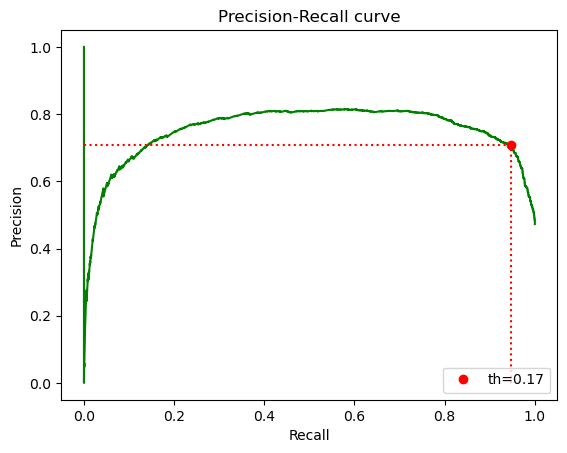

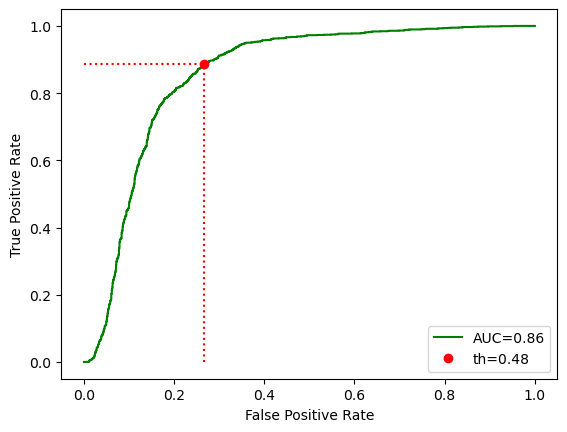

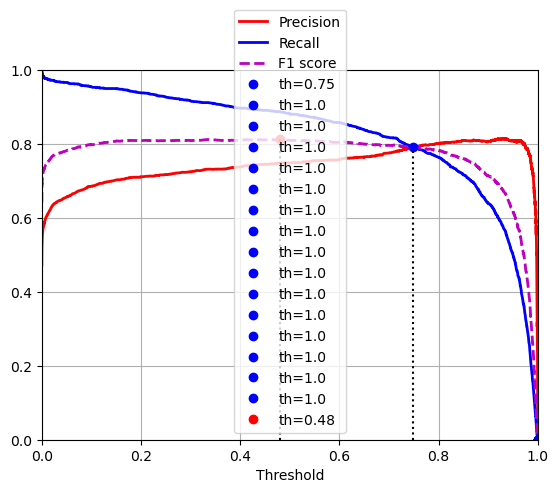

In [155]:
covid = df[df.dataset == 'covid']
execute_metrics(covid)

## MASCARAS

({'auc': 0.6020344230830034,
  'younden': 0.9999353885650636,
  'pr_max': 0.6508296728134155,
  'pr_cut': 0.999909281730652,
  'f1_score_younden': 0.5762569770987195,
  'precision_score_younden': 0.5772391322152836,
  'recall_score_younden': 0.5780297661233168,
  'accuracy_score_younden': 0.5780297661233168,
  'f1_score_pr_max': 0.3322360160877505,
  'precision_score_pr_max': 0.711983999196404,
  'recall_score_pr_max': 0.4897708480982755,
  'accuracy_score_pr_max': 0.4897708480982755,
  'f1_score_pr_cut': 0.5726907630522088,
  'precision_score_pr_cut': 0.5726907630522088,
  'recall_score_pr_cut': 0.5726907630522088,
  'accuracy_score_pr_cut': 0.5726907630522088,
  'f1_score_0.5': 0.3265471671468727,
  'precision_score_0.5': 0.7120730992896124,
  'recall_score_0.5': 0.48731396172927,
  'accuracy_score_0.5': 0.48731396172927,
  'f1_score_max': 0.32624043480143283,
  'precision_score_max': 0.7111971843307493,
  'recall_score_max': 0.4871722182849043,
  'accuracy_score_max': 0.487172218284

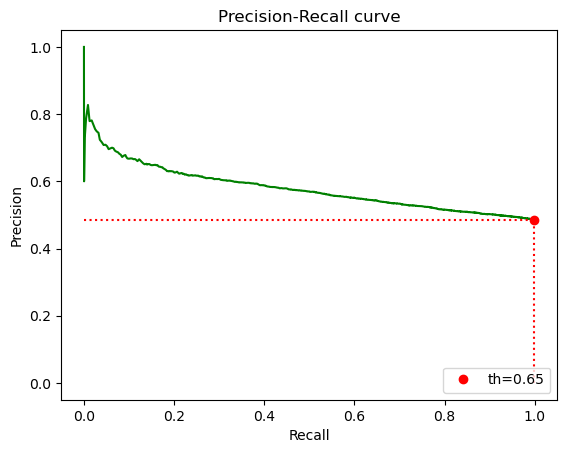

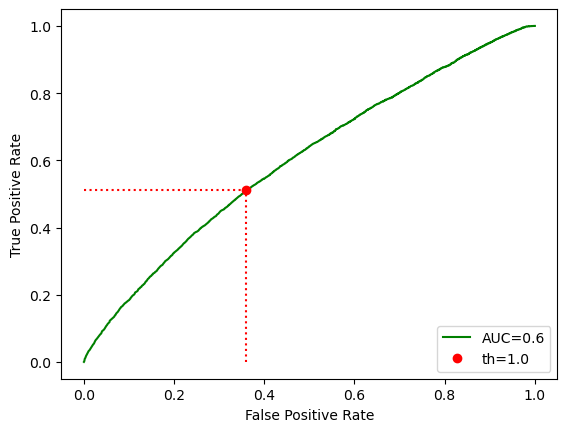

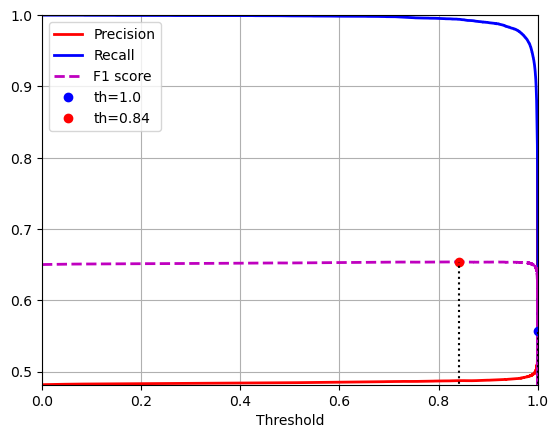

In [156]:
masks = df[df.dataset == 'masks']
execute_metrics(masks)

## SEGUN LA CLASE

In [157]:
np.unique(df['class'])

array(['Lung_Opacity', 'bacterial', 'covid', 'normal', 'pneumonia',
       'viral'], dtype=object)

In [158]:
for clase in np.unique(df['class']):
    print('{}: {}'.format(clase, sum(np.array(df['class'] == clase))))

Lung_Opacity: 6012
bacterial: 2772
covid: 5141
normal: 13292
pneumonia: 176
viral: 2838


({'auc': 0.6222390826656976,
  'younden': 0.179149180650711,
  'pr_max': 0.0231178738176822,
  'pr_cut': 0.9871938824653624,
  'f1_score_younden': 0.7070492844168447,
  'precision_score_younden': 0.7504307175182627,
  'recall_score_younden': 0.7580426409157489,
  'accuracy_score_younden': 0.7580426409157489,
  'f1_score_pr_max': 0.6959934968353501,
  'precision_score_pr_max': 0.7938679991359654,
  'recall_score_pr_max': 0.7617859274127923,
  'accuracy_score_pr_max': 0.7617859274127923,
  'f1_score_pr_cut': 0.6417295068626918,
  'precision_score_pr_cut': 0.6417295068626919,
  'recall_score_pr_cut': 0.6417295068626919,
  'accuracy_score_pr_cut': 0.6417295068626919,
  'f1_score_0.5': 0.6972701557125168,
  'precision_score_0.5': 0.7051235498083576,
  'recall_score_0.5': 0.7362881788097434,
  'accuracy_score_0.5': 0.7362881788097434,
  'f1_score_max': 0.6976357716257201,
  'precision_score_max': 0.7066140876580624,
  'recall_score_max': 0.7373189388596538,
  'accuracy_score_max': 0.73731893

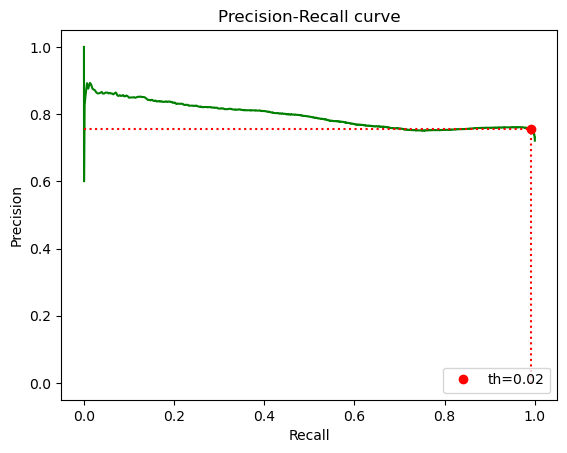

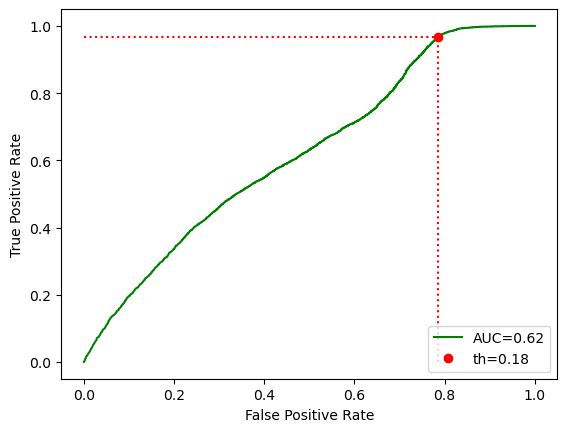

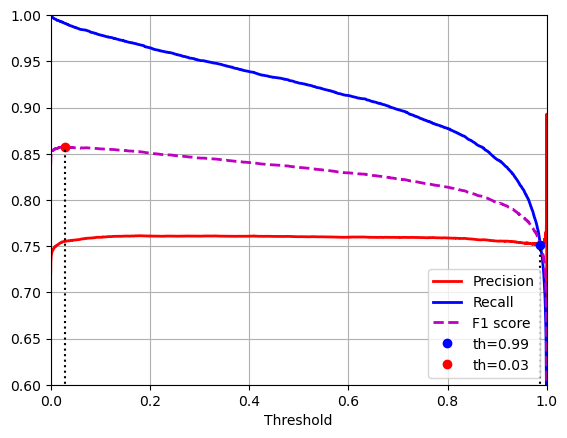

In [159]:
d = df[(df['class'] == 'covid') | (df.real == 1)].reset_index(drop = True)
execute_metrics(d)